# Setup

In [1]:
import numpy as np
from agents_clean import Agent
from model_clean import Model
from hybrid_networks_clean import rewire_network, randomize_network, create_hybrid_network
from tqdm import tqdm
import networkx as nx
import pandas as pd
import random
import numbers
#import opinionated
import matplotlib.pyplot as plt
#plt.style.use("opinionated_rc")
import colormaps as cmaps  

# Generate Parameters

In [2]:
# The networks we are considering are either multigraph (scale free), or undirected (Barabasi-Albert)
# that is why we transform them to fit, and to also get the parameters we want
def convert_multidigraph_to_digraph(G):
    # Initialize a new DiGraph
    H = nx.DiGraph()
    
    # Add nodes from the MultiDiGraph
    H.add_nodes_from(G.nodes(data=True))
    
    # Iterate over edges in the MultiDiGraph and add them to the DiGraph
    for u, v, data in G.edges(data=True):
        if H.has_edge(u, v):
            # If edge already exists, you might want to update the attributes
            # Here, we can accumulate weights as an example
            H[u][v]['weight'] += data.get('weight', 1)
        else:
            H.add_edge(u, v, **data)
            if 'weight' not in H[u][v]:
                H[u][v]['weight'] = 1  # Default weight if not provided
    
    return H


def directed_barabasi_albert_graph(G):
    # Step 2: Initialize a directed graph
    directed_graph = nx.DiGraph()
    
    # Step 3: Add nodes
    directed_graph.add_nodes_from(G.nodes(data=True))
    
    # Step 4: Add edges with direction
    for u, v in G.edges():
        if random.random() > 0.5:
            directed_graph.add_edge(u, v)
        else:
            directed_graph.add_edge(v, u)
    
    return directed_graph

def nth_moment(g,n):
    degree_np = np.array(list(dict(g.degree).values()))
    return (sum(degree_np**n)/len(g))

In [5]:
def generate_parameters(n,rewiring_type='randomize',network_type='ba'):
    params_list = []
    #print('Generating parameters...')
    for _ in tqdm(range(n),desc="Generating parameters"):
        n_agents = random.randint(11, 200)
        ba_degree = random.randint(2, 10)
        er_prob=random.uniform(0, 0.25)
        p_rewiring = random.uniform(0, 1)
        if rewiring_type=='hierarchical': # test
            G_er = nx.gnp_random_graph(n_agents, er_prob, directed=True)
            network = rewire_network(G_er, p_rewiring=p_rewiring)
        if rewiring_type=='randomize':
            if network_type=='ba':
                G = nx.to_directed(nx.barabasi_albert_graph(n_agents, ba_degree))
                #G = directed_barabasi_albert_graph(nx.barabasi_albert_graph(n_agents, ba_degree))
                network = randomize_network(G, p_rewiring=p_rewiring)
            if network_type=='sf':
                G = convert_multidigraph_to_digraph(nx.scale_free_graph(n_agents))
                network = randomize_network(G, p_rewiring=p_rewiring)
            if network_type=='ws':
                network=nx.watts_strogatz_graph(n_agents, ba_degree, p=p_rewiring, seed=None)                        
        # Calculate the mean degree of each node
        degrees = dict(network.degree())
        mean_degree = sum(degrees.values()) / len(degrees)
        avg_clustering = nx.average_clustering(network)
        try:
            avg_short_path_lenght = nx.average_shortest_path_length(network)
        except:
            avg_short_path_lenght = 0
        density = nx.density(network)
        degree_variance = nth_moment(network,2)
        #flow_hierarchy = flow_hierarchy(network)
        uncertainty = random.uniform(0.0001,0.001)
        n_experiments = random.randint(10, 100)
        params = {
            "n_agents": n_agents,
            "ba_degree": ba_degree,
            "er_prob":er_prob,
            "p_rewiring": p_rewiring,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments,
            "rewiring_type":rewiring_type,
            'mean_degree':mean_degree,
            'density': density,
            'avg_clustering': avg_clustering,
            'avg_short_path_lenght':avg_short_path_lenght,
            'degree_variance': degree_variance,
            'network_type': network_type
        }
        params_list.append(params)
    return params_list

In [6]:
# Example usage
parameter_dictionaries = generate_parameters(2,rewiring_type='randomize',network_type='ba')  # Generate parameter dictionaries
parameter_dictionaries

Generating parameters: 100%|██████████| 2/2 [00:00<00:00, 126.86it/s]


[{'n_agents': 96,
  'ba_degree': 3,
  'er_prob': 0.15644297257271625,
  'p_rewiring': 0.8674811073743718,
  'network': <networkx.classes.digraph.DiGraph at 0x130233350>,
  'uncertainty': 0.0008623026873555645,
  'n_experiments': 10,
  'rewiring_type': 'randomize',
  'mean_degree': 11.604166666666666,
  'density': 0.061074561403508774,
  'avg_clustering': 0.058824682930740675,
  'avg_short_path_lenght': 0,
  'degree_variance': 144.91666666666666,
  'network_type': 'ba'},
 {'n_agents': 47,
  'ba_degree': 2,
  'er_prob': 0.03085239509161722,
  'p_rewiring': 0.9338808577046231,
  'network': <networkx.classes.digraph.DiGraph at 0x130d73b90>,
  'uncertainty': 0.0006950663425660157,
  'n_experiments': 60,
  'rewiring_type': 'randomize',
  'mean_degree': 7.617021276595745,
  'density': 0.08279370952821462,
  'avg_clustering': 0.08004849941468829,
  'avg_short_path_lenght': 0,
  'degree_variance': 63.702127659574465,
  'network_type': 'ba'}]

# Simulation Functions

In [8]:
def run_simulation_with_params(param_dict, number_of_steps=10000, agent_type="bayes"):
    # Extract the network directly since it's already a NetworkX graph object
    my_network = param_dict['network']
    #agent_type = param_dict['agent_type']
    # Other parameters are directly extracted from the dictionary
    my_model = Model(my_network, n_experiments=param_dict['n_experiments'], uncertainty=param_dict['uncertainty']
                    , agent_type=agent_type)
    # Run the simulation with predefined steps and show_bar option
    
    my_model.run_simulation(number_of_steps=number_of_steps, show_bar=False)
  
    

    result_dict = {
        key: value 
        for key, value in param_dict.items() 
        if isinstance(value, (numbers.Number, str, tuple, list))}   
    result_dict['true_consensus'] = my_model.conclusion
    #result_dict['true_consensus_alternative_stop'] = my_model.conclusion_alternative_stop
    #df = pd.DataFrame(my_model.agents_choices) 
    #result_dict['choice_consensus'] = df.mean()[len(df.mean())-1]
    result_dict['convergence_step'] = my_model.n_steps # takes note of the last reported step
    result_dict['agent_type']=agent_type
    result_dict['n_experiments']=param_dict['n_experiments']
    result_dict['network_type']=param_dict['network_type']
    
    return result_dict


def run_simulations(param_list, number_of_steps=10000,agent_type="bayes"):
    def run_simulation(param_dict):
        return run_simulation_with_params(param_dict, number_of_steps=number_of_steps, agent_type=agent_type)
    
    results = []
    # Iterate over each parameter dictionary in the list
    for params in tqdm(param_list, desc="Running simulations"):
        result = run_simulation(params)
        results.append(result)
    
    # Convert the list of results into a Pandas DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Run Simulations

In [34]:
# Test Simulation
parameter_dictionaries = generate_parameters(2,rewiring_type='randomize',network_type='ba')  # Generate parameter dictionaries
#print(parameter_dictionaries)
test_results_df = run_simulations(parameter_dictionaries, number_of_steps=10000, agent_type="bayes")
test_results_df.to_csv('./results_data/test_results_df.csv', index=False)
test_results_df.head()

Generating parameters:   0%|          | 0/2 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 2/2 [00:10<00:00,  5.21s/it]


,n_agents,ba_degree,er_prob,p_rewiring,uncertainty,n_experiments,rewiring_type,mean_degree,density,avg_clustering,avg_short_path_lenght,degree_variance,network_type,true_consensus,convergence_step,agent_type
0,116,7,0.020986,0.652107,0.000970,95,randomize,25.741379,0.111919,0.123732,2.103748,719.551724,ba,1.0,1930,bayes
1,169,5,0.107875,0.274761,0.000592,99,randomize,19.124260,0.056917,0.079180,2.482671,471.964497,ba,1.0,8536,bayes


In [35]:
# Bayes Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 5 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        for type_of_network in ['ba','sf','ws']:
            parameter_dictionaries = generate_parameters(n_sims,rewiring_type=rewiring_type,
                                                         network_type=type_of_network)  # Generate parameter dictionaries
            results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                          agent_type="bayes")
            bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
        
    bayes_results_df.to_csv('./results_data/bayesagent_results_df.csv', index=False)

saved_bayes_results_df = pd.read_csv('./results_data/bayesagent_results_df.csv')

add_simulations = True
if add_simulations:
    n_sims = 450 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        for type_of_network in ['ba','sf','ws']:
            parameter_dictionaries = generate_parameters(n_sims,rewiring_type=rewiring_type,
                                                         network_type=type_of_network)  # Generate parameter dictionaries
            results_df1 = run_simulations(parameter_dictionaries, number_of_steps=10000, 
                                          agent_type="bayes")
            bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    bayes_results_df = pd.concat([saved_bayes_results_df, bayes_results_df], ignore_index=True)
    bayes_results_df.to_csv('./results_data/bayesagent_results_df.csv', index=False)
else: 
    bayes_results_df=saved_bayes_results_df
    
bayes_results_df.info()

Generating parameters:   0%|          | 0/450 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 450/450 [37:25<00:00,  4.99s/it]
/var/folders/f5/dc26gyt54fs5nkjnk09tb5rw0000gp/T/ipykernel_4799/812574897.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
Running simulations: 100%|██████████| 450/450 [32:55<00:00,  4.39s/it]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   n_agents               1500 non-null   object 
 1   ba_degree              1500 non-null   object 
 2   er_prob                1500 non-null   float64
 3   p_rewiring             1500 non-null   float64
 4   uncertainty            1500 non-null   float64
 5   n_experiments          1500 non-null   object 
 6   rewiring_type          1500 non-null   object 
 7   mean_degree            1500 non-null   float64
 8   density                1500 non-null   float64
 9   avg_clustering         1500 non-null   float64
 10  avg_short_path_lenght  1500 non-null   float64
 11  degree_variance        1500 non-null   float64
 12  network_type           1500 non-null   object 
 13  true_consensus         1500 non-null   float64
 14  convergence_step       1500 non-null   object 
 15  agen

In [36]:
# Beta Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 5
    beta_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:        
        for type_of_network in ['ba','sf','ws']:
            parameter_dictionaries = generate_parameters(n_sims,rewiring_type=rewiring_type,
                                                         network_type=type_of_network)  # Generate parameter dictionaries
            results_df1 = run_simulations(parameter_dictionaries, 
                                          number_of_steps=10000, agent_type="beta")
            beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)

    beta_results_df.to_csv('./results_data/betaagent_results_df.csv', index=False)

saved_beta_results_df = pd.read_csv('./results_data/betaagent_results_df.csv')

add_simulations = True
if add_simulations:
    n_sims = 450 # this is for each type of rewiring
    beta_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['randomize']:
        for type_of_network in ['ba','sf','ws']:
            parameter_dictionaries = generate_parameters(n_sims,rewiring_type=rewiring_type,
                                                         network_type=type_of_network)  # Generate parameter dictionaries
            results_df1 = run_simulations(parameter_dictionaries, 
                                          number_of_steps=10000, agent_type="beta")
            beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
        
    beta_results_df = pd.concat([saved_beta_results_df, beta_results_df], ignore_index=True)
    beta_results_df.to_csv('./results_data/betaagent_results_df.csv', index=False)
else:
    beta_results_df = saved_beta_results_df

beta_results_df.info()

Running simulations: 100%|██████████| 450/450 [05:18<00:00,  1.41it/s]
/var/folders/f5/dc26gyt54fs5nkjnk09tb5rw0000gp/T/ipykernel_4799/4165113238.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
Running simulations: 100%|██████████| 450/450 [06:56<00:00,  1.08it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   n_agents               1500 non-null   object 
 1   ba_degree              1500 non-null   object 
 2   er_prob                1500 non-null   float64
 3   p_rewiring             1500 non-null   float64
 4   uncertainty            1500 non-null   float64
 5   n_experiments          1500 non-null   object 
 6   rewiring_type          1500 non-null   object 
 7   mean_degree            1500 non-null   float64
 8   density                1500 non-null   float64
 9   avg_clustering         1500 non-null   float64
 10  avg_short_path_lenght  1500 non-null   float64
 11  degree_variance        1500 non-null   float64
 12  network_type           1500 non-null   object 
 13  true_consensus         1500 non-null   float64
 14  convergence_step       1500 non-null   object 
 15  agen

# Now Some Plotting

## Basic Plotting

In [37]:
def plot_results(results_df=bayes_results_df, variable_of_interest='true_consensus', regressor='n_agents', agent_type='Bayes'):
    # Grouping the data by network type and regressor and calculating the mean for the variable of interest
    grouped = results_df.groupby(['network_type', regressor])[variable_of_interest].mean().reset_index()

    # Preparing the figure
    plt.figure(figsize=(10, 8))

    # Looping over each network type and plotting the corresponding line
    for network_type in results_df['network_type'].unique():
        subset = grouped[grouped['network_type'] == network_type]
        plt.plot(subset[regressor], subset[variable_of_interest], marker='o', label=network_type)

    # Setting the labels and title
    plt.xlabel(regressor)
    plt.ylabel('Share of ' + variable_of_interest)
    plt.title(agent_type+': '+ 'Share of ' + variable_of_interest + ' by ' + regressor)
    
    # Adding the legend for network types
    plt.legend(title='Network Type')

    # Enabling grid
    plt.grid(True)
    
    # Display the plot
    plt.show()


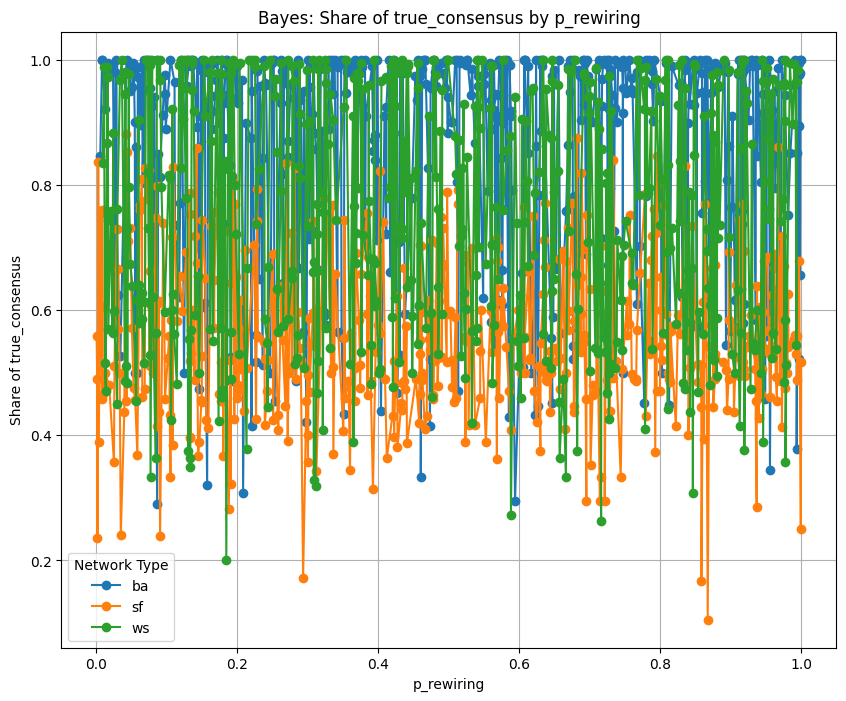

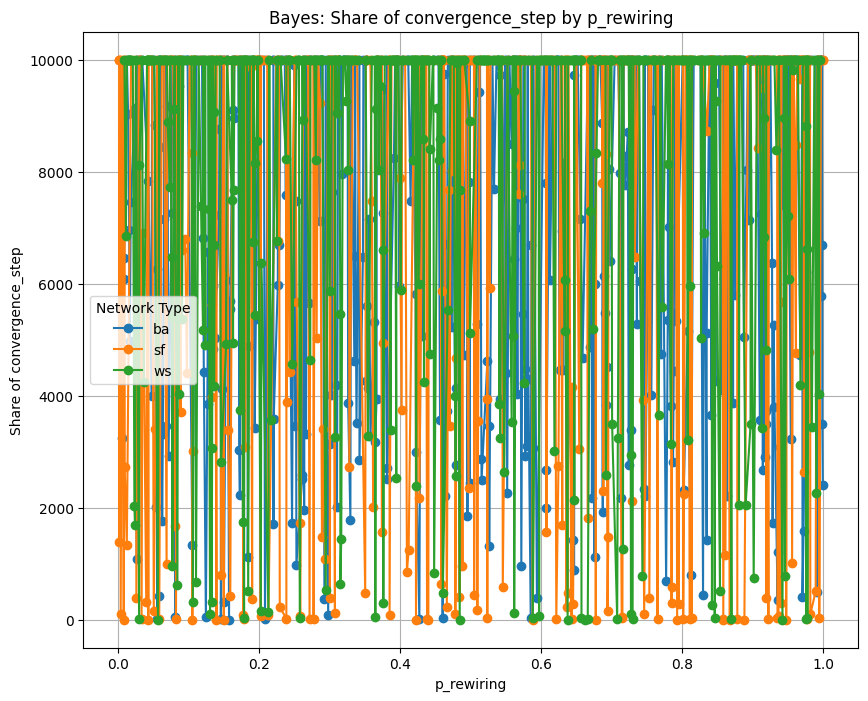

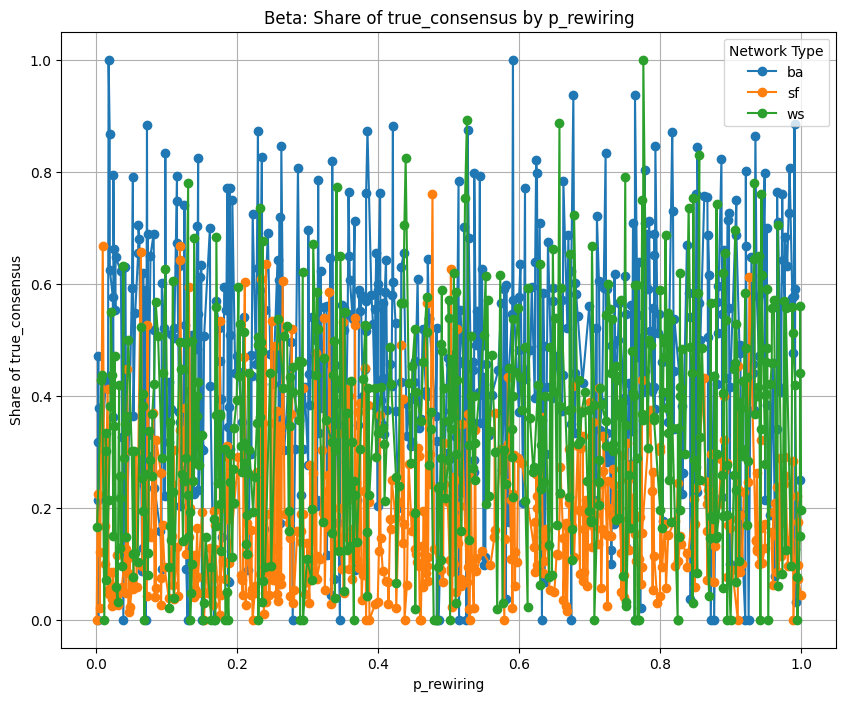

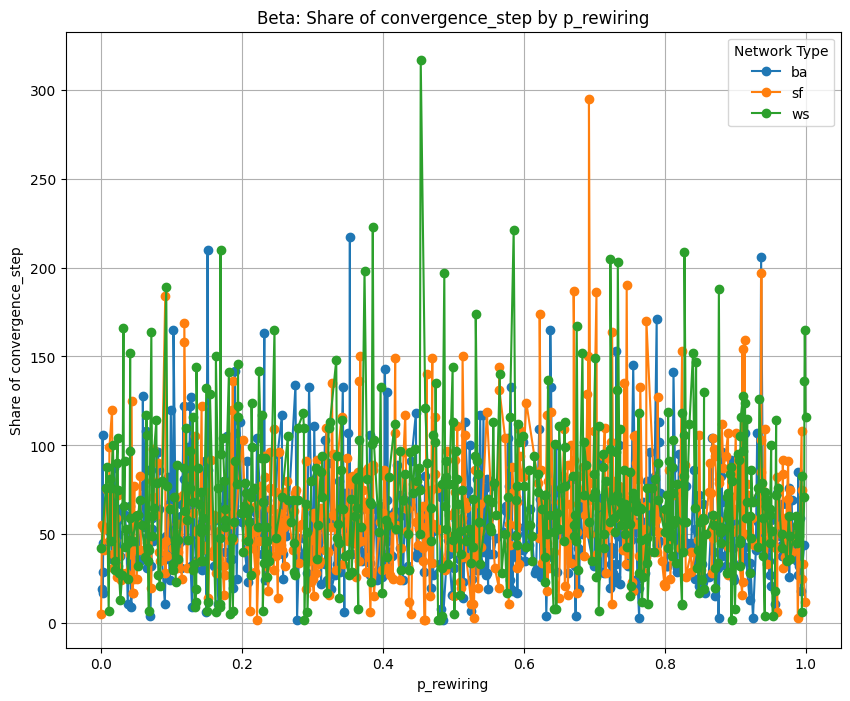

In [38]:
plot_results(bayes_results_df,variable_of_interest = 'true_consensus',regressor = 'p_rewiring',agent_type='Bayes')
plot_results(bayes_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring',agent_type='Bayes')
plot_results(beta_results_df,variable_of_interest = 'true_consensus',regressor = 'p_rewiring',agent_type='Beta')
plot_results(beta_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring',agent_type='Beta')

# CODE FINISHES HERE, REST IS EXPERIMENTAL

# More Advanced Plotting

In [ ]:
from pygam import LogisticGAM, s
from sklearn.model_selection import train_test_split

In [ ]:
bayes_results_df.info()

## First Just on Number of Agents

In [ ]:
def do_regression(results_df=bayes_results_df,variable_of_interest = 'true_consensus'):
    # Splitting the DataFrame by network type
    network_types = results_df['rewiring_type'].unique()

    my_gams = {}

    for network_type in network_types:
        # Subset the DataFrame by network type
        subset = results_df[results_df['rewiring_type'] == network_type]
        
        # Preparing the data
        X = subset[['n_agents','uncertainty','p_rewiring','mean_degree']]
        y = subset[variable_of_interest]#.astype(int)  # Convert boolean to integer
        
        # Splitting the data into training and testing sets for model validation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Fitting the Logistic GAM model
        gam = LogisticGAM(s(0,n_splines=6)).fit(X_train, y_train)
        
        # Storing the model
        my_gams[network_type] = gam
        
        # Optionally, you can print out model accuracy or other statistics here
        print(f"Model for {network_type}:")
        print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
        print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
        print("-" * 30)
        
    return my_gams,X

do_regression()

In [ ]:
def do_regression(results_df=bayes_results_df,variable_of_interest = 'true_consensus'):
    # Splitting the DataFrame by network type
    network_types = results_df['rewiring_type'].unique()

    my_gams = {}

    for network_type in network_types:
        # Subset the DataFrame by network type
        subset = results_df[results_df['rewiring_type'] == network_type]
        
        # Preparing the data
        X = subset[['n_agents','uncertainty','p_rewiring','mean_degree']]
        y = subset[variable_of_interest]#.astype(int)  # Convert boolean to integer
        
        # Splitting the data into training and testing sets for model validation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Fitting the Logistic GAM model
        gam = LogisticGAM(s(0,n_splines=6)).fit(X_train, y_train)
        
        # Storing the model
        my_gams[network_type] = gam
        
        # Optionally, you can print out model accuracy or other statistics here
        print(f"Model for {network_type}:")
        print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
        print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
        print("-" * 30)
        
    return my_gams,X

do_regression()

In [ ]:
X.head()

In [ ]:
def plot_regression(results_df=bayes_results_df,variable_of_interest = 'true_consensus'):
    my_gams,X = do_regression(results_df=results_df,variable_of_interest = variable_of_interest)
    # Set the size of the figure
    plt.figure(figsize=(10, 6))

    cmap= cmaps.colorblind_10

    X_range = np.linspace(X['n_agents'].min(), X['n_agents'].max(), 100)

    colors =[cmap(0), cmap(1/cmap.N), cmap(1/cmap.N*2)]

    for i, (network_type, gam) in enumerate(my_gams.items()):
        conf = gam.confidence_intervals(X_range.reshape(-1, 1), width=0.95, quantiles=None)
        plt.fill_between(X_range, conf[:, 0], conf[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)


    for i, (network_type, gam) in enumerate(my_gams.items()):
        # Generating a range of values for n_agents to predict and plot
        # Predicting with the model
        #y_pred, conf = pdep, confi = model.partial_dependence(term=0, width=.95)
        y_pred = gam.predict_proba(X_range.reshape(-1, 1))

        # Plotting predicted probabilities
        plt.plot(X_range, y_pred,c=colors[i], label=f'{network_type}')
        
    # Adding title, labels, and legend
    plt.title('Effect of n_agents on '+ variable_of_interest +' Probability')
    plt.xlabel('Number of Agents')
    plt.ylabel('Probability of ' +variable_of_interest)
    plt.legend()
    plt.show()

In [ ]:
plot_regression(bayes_results_df)

In [ ]:
plot_full(results_df=bayes_results_df,variable_of_interest = 'true_consensus')
plot_full(results_df=bayes_results_df,variable_of_interest = 'choice_consensus')
plot_full(results_df=bayes_results_df,variable_of_interest = 'convergence_step')